# E5_ 프로젝트: Spectrogram classification 모델 구현
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
  - 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
  - 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
  - evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.

## 1. 데이터 처리와 분류
* 라벨 데이터 처리하기
* sklearn의 train_test_split함수를 이용하여 train, test 분리

### 1-1. 음성 데이터 읽기

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# 간단한 단어인식(음성인식) 모델을 위한 훈련 데이터셋
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

# npz 파일의 요소 이름 확인
for f in speech_data.files:
    print(f)

wav_vals
label_vals


* 음성 데이터는 "wav_vals" 파일과 "label_vals" 파일로 구성되어 있다.

In [3]:
# speech_data 형태 확인
wave_data = speech_data["wav_vals"]
label_data = speech_data["label_vals"]

print("Wave data shape : ", wave_data.shape)
print("Label data shape : ", label_data.shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


* 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이루어짐
* 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling함

In [4]:
# 음성 데이터와 레이블 데이터가 맞는지 확인
import IPython.display as ipd
import random

# 데이터 선택 
rand = random.randint(0, len(wave_data))

print("Wave data shape : ", wave_data[rand].shape)
print("label : ", label_data[rand])

sr = 8000      # 1초동안 재생되는 샘플의 갯수
ipd.Audio(wave_data[rand], rate=sr)

Wave data shape :  (8000,)
label :  ['on']


### 1-2. Label data 처리

In [5]:
# 오디오 클립의 레이블
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list

# 추가 레이블
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)


# Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업
new_label_value = dict()

for i, l in enumerate(label_value):
    new_label_value[l] = i
    
label_value = new_label_value
inv_label_value = {v: k for k, v in label_value.items()}
# reverse_label_value = dict(map(reversed, label_value.items()))

print('Indexed LABEL : ', label_value)
print("Reverse label : ", inv_label_value)


LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}
Reverse label :  {0: 'yes', 1: 'no', 2: 'up', 3: 'down', 4: 'left', 5: 'right', 6: 'on', 7: 'off', 8: 'stop', 9: 'go', 10: 'unknown', 11: 'silence'}


In [6]:
# 레이블 데이터를 정수(int)로 이뤄진 index 작업
temp = []
i = 0
for v in label_data:
    temp.append(new_label_value[v[0]])
    
label_data = np.array(temp)

print(label_data.shape)
label_data

(50620,)


array([ 3,  3,  3, ..., 11, 11, 11])

### 1-3. 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
**STFT(Short Time Fourier Transform)** : Time 도메인의 파형을 Frequency 도메인으로 변형시키는 푸리에 변환 
* wav 데이터가 단위 시간만큼 STFT을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성

In [7]:
import librosa

# STFT 변환
def wav2spec(wav, fft_size=258):                   # spectrogram shape을 맞추기위해서 size 변형
    # STFT
    stft = librosa.stft(wav, n_fft=fft_size)       # n_fft : fram 하나당 sample 수
    
    # 복소수공간 값 절대값 취하기
    magnitude = np.abs(stft)  
    
    return magnitude

# 모든 음성 데이터 STFT 변환
spec_data = []

for wav in speech_data["wav_vals"]:
    spec_data.append(wav2spec(wav))

spec_data = np.array(spec_data)

print(wave_data.shape)
print(spec_data.shape)


# 랜덤으로 뽑은 음성 데이터 1개를 STFT 변환
spec_one = wav2spec(speech_data["wav_vals"][rand]) 

(50620, 8000)
(50620, 130, 126)


* 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
  * tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 준다.   
  
```Python
del speech_data
del spec_data
```

In [8]:
# 메모리 버퍼 삭제
del wave_data
del speech_data

In [9]:
# ISTFT 변환
def spec2wav(spec):
    inv_stft = librosa.istft(spec) 
    return inv_stft

# # 모든 스펙트럼 데이터 ISTFT 변환
# sound_data = []
# for spec in spec_data:
#     wav = spec2wav(spec)
#     sound_data.append(wav)
    
# sound_data = np.array(sound_data)
# print(sound_data.shape)


# 랜덤으로 뽑은 스펙트럼 데이터 1개를 ISTFT 변환
# sound_one = sound_data[rand]
sound_one = np.array(spec2wav(spec_data[rand]))
print(sound_one.shape)

# 스펙트럼 데이터 ISTFT 변환 후 음성 확인 
print("label : ", inv_label_value.get(label_data[rand]))

sr = 8000      
ipd.Audio(sound_one, rate=sr)

(8000,)
label :  on


In [10]:
print(spec_data.shape)
print(spec_data[rand].shape)
print(spec2wav(spec_data[rand]).shape)

(50620, 130, 126)
(130, 126)
(8000,)


### 1-4. 학습을 위한 데이터 분리

In [11]:
from sklearn.model_selection import train_test_split

# train / test 데이터셋 분리
train_wav, test_wav, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

In [12]:
# 메모리 버퍼 삭제
del spec_data

In [13]:
# train / validation 데이터셋 분리
train_wav, valid_wav, train_label, valid_label = train_test_split(train_wav, 
                                                                train_label, 
                                                                test_size=0.1,
                                                                shuffle=True)

print('train_wav :', train_wav.shape)
# print('valid_wav :', valid_wav.shape)
print('test_wav :', test_wav.shape)

train_wav : (41002, 130, 126)
test_wav : (5062, 130, 126)


### 1-5. spec_data 1개 spectrogram 그려보기

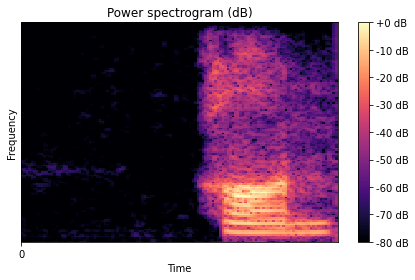

In [14]:
import librosa.display

# magnitude -> Decibels
log_spectrogram = librosa.amplitude_to_db(spec_one, ref=np.max)

# display spectrogram
librosa.display.specshow(log_spectrogram,sr=sr)  # x_axis='time'

plt.title('Power spectrogram (dB)')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 2. 학습을 위한 하이퍼파라미터 설정

In [15]:
batch_size = 32
max_epochs = 10    # 10


## 3. 데이터셋 구성
* `tf.data.Dataset`을 이용
* `from_tensor_slices 함수`에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
* `map과 batch`를 이용한 데이터 전처리

In [16]:
def one_hot_label(wav, label):
    # 레이블 개수(12개)의 one-hot인코딩 
    num_label = len(label_value)
    label = tf.one_hot(label, depth=num_label)
    return wav, label

In [17]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))  # 입력된 텐서로부터 slices를 생성
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for validation
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_wav, valid_label))  # 입력된 텐서로부터 slices를 생성
valid_dataset = valid_dataset.map(one_hot_label)
valid_dataset = valid_dataset.batch(batch_size=batch_size)
print(valid_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)  # test_dataset에서는 repeat() 수행하지 않음
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
* **2차원 Spectrogram 데이터**의 시간축 방향으로 **Conv1D layer**를 적용, 혹은 **Conv2D layer**를 적용 가능
* **batchnorm, dropout, dense layer** 등을 이용
* 12개의 단어 class를 구분하는 loss를 사용하고 **Adam optimizer**를 사용
* 모델 가중치를 저장하는 **`checkpoint callback 함수`** 추가
* 다양한 모델의 실험을 진행해 보시기 바랍니다.

### 4-1. Skip-Connection model 사용

In [18]:
# Skip-Connection model에 Conv2D 사용
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(spec_one.shape[0], spec_one.shape[1], 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### 4-2. Loss

In [19]:
# 손실 최적화 모델 설정
optimizer=tf.keras.optimizers.Adam(1e-4)

# 모델 훈련 설정
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 4-3. validation loss 모니터
* model.fit 함수를 이용할 때, callback 함수를 이용해서 학습 중간 중간 원하는 동작을 하도록 설정
* 모델을 재사용하기위해서 모델 가중치를 저장하는 callback 함수를 추가

In [20]:
# save checkpoint
MODEL_SAVE_FOLDER_PATH = os.getenv('HOME') + '/aiffel/speech_recognition/models/wav_skip'

if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
  os.mkdir(MODEL_SAVE_FOLDER_PATH)

print(MODEL_SAVE_FOLDER_PATH)

# model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# loss가 낮아지면 모델 파라미터를 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_FOLDER_PATH,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

/home/aiffel-d34j/aiffel/speech_recognition/models/wav_skip


### 4-4. 모델 훈련

In [21]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, 
                                      epochs=max_epochs,
                                      steps_per_epoch=len(train_wav) // batch_size,
                                      validation_data=valid_dataset,
                                      validation_steps=len(valid_wav) // batch_size,
                                      callbacks=[cp_callback])

Epoch 1/10
1281/1281 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.7629
Epoch 00001: val_loss improved from inf to 0.27188, saving model to /home/aiffel-d34j/aiffel/speech_recognition/models/wav_skip
1281/1281 [==============================] - 192s 150ms/step - loss: 0.7257 - accuracy: 0.7629 - val_loss: 0.2719 - val_accuracy: 0.9133
Epoch 2/10
1281/1281 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9295
Epoch 00002: val_loss improved from 0.27188 to 0.19611, saving model to /home/aiffel-d34j/aiffel/speech_recognition/models/wav_skip
1281/1281 [==============================] - 194s 151ms/step - loss: 0.2190 - accuracy: 0.9295 - val_loss: 0.1961 - val_accuracy: 0.9344
Epoch 3/10
1281/1281 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9546
Epoch 00003: val_loss improved from 0.19611 to 0.14629, saving model to /home/aiffel-d34j/aiffel/speech_recognition/models/wav_skip
1281/1281 [=============================

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
* loss, accuracy를 그래프로 표현

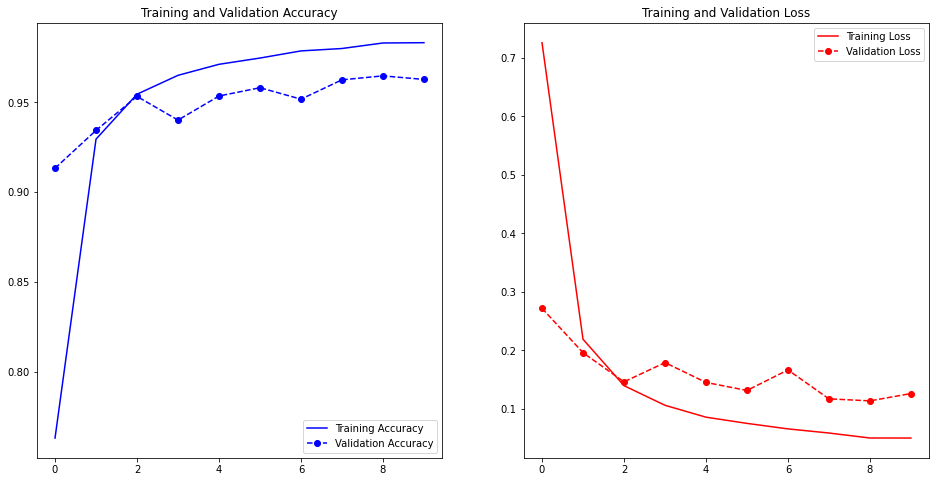

In [22]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss = history_wav_skip.history['loss']
val_loss = history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

# Accuracy graph
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'bo--', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'r', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro--', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Test dataset을 이용해서 모델의 성능을 평가
* 저장한 weight 불러오기
* 모델의 예측값과 정답값이 얼마나 일치하는지 확인

### 6-1. Evaluation

In [23]:
# checkpoint callback 함수가 저장한 weight를 다시 불러와서 테스트 준비
model_wav_skip.load_weights(MODEL_SAVE_FOLDER_PATH)

# Test data을 이용하여 모델의 예측값과 실제값이 얼마나 일치하는지 확인 
results = model_wav_skip.evaluate(test_dataset)


print("loss value: {:.3f}".format(results[0]))            # loss
print("accuracy value: {:.4f}%".format(results[1]*100))   # accuracy

159/159 [==============================] - 23s 144ms/step - loss: 0.1134 - accuracy: 0.9648
loss value: 0.113
accuracy value: 96.4836%


### 6-2. Model Test

In [24]:
# Test data 셋에서 임으로 1개 선택
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]

# 모델이 예측한 값
y_pred_ = model_wav_skip(batch_xs, training=False)

# 예측한 스펙토그램 데이터를 웨이브 데이터로 변환
sound_one = batch_xs.reshape(-1, batch_xs.shape[2])
sound_one = np.array(spec2wav(sound_one))

# 예측한 음성 출력
print("label : ", str(inv_label_value[batch_ys[0]]))
ipd.Audio(sound_one, rate=8000)

label :  go


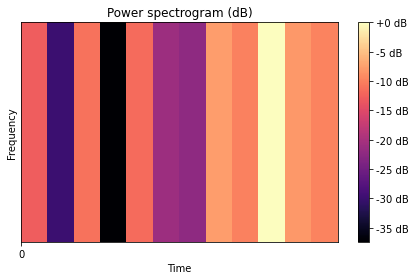

In [25]:
import librosa.display

# magnitude -> Decibels
log_spectrogram = librosa.amplitude_to_db(y_pred_, ref=np.max)

# display spectrogram
librosa.display.specshow(log_spectrogram)

plt.title('Power spectrogram (dB)')
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### 6-3. Prediction

In [26]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: go(Correct!)


## 7. 회고
1. npz 파일 내용 확인
2. librosa.stft(), librosa.istft()
3. 텐서플로 데이터 셋 만들기
4. 메모리 삭제 : 텐서 플로우에는 텐서 크기에 대해 2GB의 하드 제한
5. 학습한 웨이트 저장 : wav_skip 폴더에 저장되지 않음